In [1]:
import os
import sys
import numpy as np
import random
import skimage.io as io # this is for visualize the sequences of music samples
from struct import pack, unpack #this
from io import StringIO, BytesIO # and this are for handling the process of converting MIDI 
                                # into piano rolls
from matplotlib import pyplot as plt

import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.utils.data as data
from torch import optim
from tqdm.auto import tqdm

# stolen code to pre-process MIDI files

In [2]:
# define MIDI constants in order to configure various music controls such as 
#  pitch, channels, start of sequence, end of seqeunce, and so on
NOTE_MIDI_OFF = 0x80
NOTE_MIDI_ON = 0x90
A_TOUCH = 0xA0
CONT_CONTROL = 0xB0 
PATCH_CHG_MIDI = 0xC0
CHNL_PRESS = 0xD0
MIDI_PITCH_BND = 0xE0                                                                                  
SYS_EXCL_MIDI = 0xF0
MTC_MIDI = 0xF1
SNG_POS_MIDI_POINTER = 0xF2
SNG_SEL_MIDI = 0xF3
TUNE_REQ_MIDI = 0xF6
END_OFF_EXCL_MIDI = 0xF7 
SEQ_NUM = 0x00  
MIDI_TXT            = 0x01  
MIDI_CR       = 0x02  
SEQ_NAME_MIDI   = 0x03  
INSTR_NAME_MIDI = 0x04  
MIDI_LRC           = 0x05  
MIDI_MRKR          = 0x06  
CUEPNT_MIDI        = 0x07  
PROG_NAME_MIDI    = 0x08  
DVC_NAME     = 0x09  
CH_PREF  = 0x20  
PRT       = 0x21  
E_O_T    = 0x2F  
TMP           = 0x51  
SMTP_MIDI_OFF     = 0x54  
TIME_SIGN_MIDI  = 0x58  
KEY_SIGN_MIDI   = 0x59  
MIDI_SPEC        = 0x7F  
MIDI_TRK_HEAD    = 'MTrk'
MIDI_MET_EVNT     = 0xFF

In [3]:
# define classes that handle MIDI data input and output streams, the MIDI data parser, ...
class MOStrm:
    def __init__(self):
        self._abs_t = 0
        self._rel_t = 0
        self._cur_trk = 0
        self._run_stat = None
    def time_update(self, t_new=0, rel_flag=1):
        if rel_flag:
            self._rel_t = t_new
            self._abs_t += t_new
        else:
            self._rel_t = t_new - self._abs_t
            self._abs_t = t_new
    def t_reset(self):
        self._rel_t = 0
        self._abs_t = 0        
    def t_rel(self):
        return self._rel_t
    def t_abs(self):
        return self._abs_t    
    def set_cur_trk(self, trk_new):
        self._cur_trk = trk_new
    def midi_nt_on(self, chnl=0, nt=0x40, vel=0x40):
        pass
    def midi_nt_off(self, chnl=0, nt=0x40, vel=0x40):
        pass
    def aft_tch(self, chnl=0, nt=0x40, vel=0x40):
        pass
    def cont_ctrl(self, chnl, crtler, v):
        pass
    def pch_chg(self, chnl, pch):
        pass
    def chnl_press(self, chnl, press):
        pass
    def pch_bnd(self, chnl, v):
        pass
    def sng_pos_ptr(self, v):
        pass
    def sng_sel(self, sng_num):
        pass
    def tun_req(self):
        pass        
    def t_cod(self, typ_m, vals):
        pass
    def hdr(self, fmt=0, num_trs=1, divs=96):
        pass
    def end_of_file(self):
        pass
    def mt_evt(self, mt_typ, d):
        pass
    def s_o_trk(self, num_trk=0):
        pass
    def e_o_trk(self):
        pass
    def seq_num(self, v):
        pass
    def txt(self, txt):
        pass
    def cr(self, txt):
        pass
    def seq_nam(self, txt):
        pass
    def inst_nam(self, txt):
        pass
    def lrc(self, txt):
        pass
    def mrkr(self, txt):
        pass
    def cuepnt(self, txt):
        pass
    def ch_prf(self, chnl):
        pass
    def m_prt(self, v):
        pass
    def tmp(self, v):
        pass
    def smtp_midi_off(self, hr, mn, sec, fm, fmprt):
        pass
    def t_sign_midi(self, n, d, c, b):
        pass
    def k_sign_midi(self, s, m):
        pass
    def seq_spc(self, d):
        pass

In [4]:
class MIFl:
    def __init__(self, ostr, ifl):
        self.r_input = RIStrFl(ifl)
        self.prs = MFlPrsr(self.r_input, ostr)
    def op_rd(self):
        prs = self.prs
        prs.pMdChk()
        prs.pMTChks()
    def d_set(self, d=''):
        self.r_input.d_set(d)

In [5]:
class MOFl(MOStrm):
    def __init__(self, r_output=''):
        self.r_output = ROStrFl(r_output)
        MOStrm.__init__(self)    
    def op_wrt(self):
        self.r_output.op_wrt()
    def midi_evt_slc(self, e_slice):
        curr_track = self._cur_trk_bfr
        curr_track.op_wrt_var_len(self.t_rel())
        curr_track.op_wrt_slc(e_slice)
    def midi_nt_on(self, chnl=0, nt=0x40, vel=0x40):
        curr_slice = strm_to_data([NOTE_MIDI_ON + chnl, nt, vel])
        self.midi_evt_slc(curr_slice)
    def midi_nt_off(self, chnl=0, nt=0x40, vel=0x40):
        curr_slice = strm_to_data([NOTE_MIDI_OFF + chnl, nt, vel])
        self.midi_evt_slc(curr_slice)
    def aft_tch(self, chnl=0, nt=0x40, vel=0x40):
        curr_slice = strm_to_data([A_TOUCH + chnl, nt, vel])
        self.midi_evt_slc(curr_slice)
    def cont_ctrl(self, chnl, ctrler, v):
        curr_slice = strm_to_data([CONT_CONTROL + chnl, ctrler, v])
        self.midi_evt_slc(curr_slice)
    def pch_chg(self, chnl, pch):
        curr_slice = strm_to_data([PATCH_CHG_MIDI + chnl, pch])
        self.midi_evt_slc(curr_slice)
    def chnl_press(self, chnl, press):
        curr_slice = strm_to_data([CHNL_PRESS + chnl, press])
        self.midi_evt_slc(curr_slice)
    def pch_bnd(self, chnl, v):
        m = (v>>7) & 0xFF
        l = v & 0xFF
        curr_slice = strm_to_data([MIDI_PITCH_BND + chnl, m, l])
        self.midi_evt_slc(curr_slice)
    def t_cod(self, typ_m, vals):
        v = (typ_m<<4) + vals
        self.midi_evt_slc(strm_to_data([MIDI_TIME_CODE, v]))
    def sng_pos_ptr(self, v):
        l = (v & 0x7F)
        m = (v >> 7) & 0x7F
        self.midi_evt_slc(strm_to_data([SNG_POS_MIDI_POINTER, l, m]))
    def sng_sel(self, sng_num):
        self.midi_evt_slc(strm_to_data([SNG_SEL_MIDI, sng_num]))
    def tun_req(self):
        self.midi_evt_slc(chr(TUNE_REQ_MIDI))
    def hdr(self, fmt=0, num_trs=1, divs=96):       
        r_data = self.r_output
        r_data.op_wrt_slc('MThd')
        b = r_data.op_bew_wrt
        b(6, 4)
        b(fmt, 2)
        b(num_trs, 2)
        b(divs, 2)
    def end_of_file(self):
        self.op_wrt()
    def m_slc(self, mt_typ, data_slice):
        slc = strm_to_data([MIDI_MET_EVNT, mt_typ]) + \
                         op_wrt_var(len(data_slice)) +  data_slice
        self.midi_evt_slc(slc)
    def mt_evt(self, mt_typ, d):
        self.m_slc(mt_typ, strm_to_data(d))
    def s_o_trk(self, num_trk=0):
        self._cur_trk_bfr = ROStrFl()
        self.t_reset()
        self._cur_trk += 1
    def e_o_trk(self):
        r_output = self.r_output
        r_output.op_wrt_slc(MIDI_TRK_HEAD)
        d_trk = self._cur_trk_bfr.fetch_val()
        e_o_t_slc = op_wrt_var(self.t_rel()) + strm_to_data([MIDI_MET_EVNT, E_O_T, 0])
        r_output.op_bew_wrt(len(d_trk)+len(e_o_t_slc), 4)
        r_output.op_wrt_slc(d_trk)
        r_output.op_wrt_slc(e_o_t_slc)
    def seq_num(self, v):
        self.m_slc(mt_typ, op_bew_wrt(v, 2))
    def midi_txt(self, txt):
        self.m_slc(MIDI_TXT, txt)
    def cr(self, txt):
        self.m_slc(MIDI_CR, txt)
    def seq_nam(self, txt):
        self.m_slc(SEQ_NAME_MIDI, txt)
    def inst_nam(self, txt):
        self.m_slc(INSTR_NAME_MIDI, txt)
    def lrc(self, txt):
        self.m_slc(MIDI_LRC, txt)
    def mrkr(self, txt):
        self.m_slc(MIDI_MRKR, txt)
    def cuepnt(self, txt):
        self.m_slc(CUEPNT_MIDI, txt)
    def ch_prf(self, chnl):
        self.m_slc(CH_PREF, chr(chnl))
    def m_prt(self, v):
        self.m_slc(CH_PREF, chr(v))
    def tmp(self, v):
        h, m, l = (v>>16 & 0xff), (v>>8 & 0xff), (v & 0xff)
        self.m_slc(TMP, strm_to_data([h, m, l]))
    def smtp_midi_off(self, hr, mn, sec, fm, fmprt):
        self.m_slc(SMTP_MIDI_OFF, strm_to_data([hr, mn, sec, fm, fmprt]))
    def t_sign_midi(self, n, d, c, b):
        self.m_slc(TIME_SIGN_MIDI, strm_to_data([n, d, c, b]))
    def k_sign_midi(self, s, m):
        self.m_slc(KEY_SIGN_MIDI, strm_to_data([s, m]))
    def seq_spc(self, d):
        self.m_slc(SEQ_SPC, d)

In [6]:
class RIStrFl:    
    def __init__(self, ifl=''):
        if ifl:
            if isinstance(ifl, str):
                ifl = open(ifl, 'rb')
                self.d = ifl.read()
                ifl.close()
            else:
                self.d = ifl.op_rd()
        else:
            self.d = ''
        self.csr = 0
    def d_set(self, d=''):
        self.d = d
    def get_csr(self):
        return self.csr
    def mv_csr(self, rl_ps=0):
        self.csr += rl_ps
    def nxt_slc(self, ln, mv_csr=1):
        c = self.csr
        slc = self.d[int(c):int(c+ln)]
        if mv_csr:
            self.mv_csr(ln)
        return slc
    def b_read(self, num_bts=1, mv_csr=1):
        return b_read(self.nxt_slc(num_bts, mv_csr))
    def op_rd_var_len(self):
        MX_VLN = 4
        v = op_rd_var(self.nxt_slc(MX_VLN, 0))
        self.mv_csr(get_len_var(v))
        return v

In [7]:
class ROStrFl:
    def __init__(self, ofl=''):
        self.bfr = BytesIO()
        self.ofl = ofl
    def op_wrt_slc(self, s_slc):
        if isinstance(s_slc, str):
            self.bfr.write(s_slc.encode())
        else:
            self.bfr.write(s_slc)
    def op_bew_wrt(self, v, ln=1):
        self.op_wrt_slc(op_bew_wrt(v, ln))
    def op_wrt_var_len(self, v):
        var = self.op_wrt_slc(op_wrt_var(v))
    def op_wrt(self):
        if self.ofl:
            if isinstance(self.ofl, str):
                ofl = open(self.ofl, 'wb')
                ofl.write(self.fetch_val())
                ofl.close()
            else:
                self.ofl.op_wrt(self.fetch_val())
        else:
            sys.stdout.op_wrt(self.fetch_val())                
    def fetch_val(self):
        return self.bfr.getvalue()

In [8]:
class MFlPrsr:
    def __init__(self, r_input, ostr):
        self.r_input = r_input
        self.dpch = EvtDspch(ostr)
        self._run_stat = None
    def pMdChk(self):
        r_input = self.r_input
        hd_chk_typ = r_input.nxt_slc(4)
        hd_chk_sz = r_input.b_read(4)
        if hd_chk_typ != b'MThd':
            raise TypeError("Invalid file type - non MIDI !")
        self.fmt = r_input.b_read(2)
        self.num_tr = r_input.b_read(2)
        self.divs = r_input.b_read(2)
        if hd_chk_sz > 6:
            r_input.mv_csr(hd_chk_sz-6)
        self.dpch.hdr(self.fmt, self.num_tr, self.divs)
    def pMTChk(self):
        self.dpch.t_reset()        
        dpch = self.dpch
        r_input = self.r_input
        dpch.s_o_trk(self._cur_trk)
        r_input.mv_csr(4)
        tr_len = r_input.b_read(4)
        tr_end = r_input.get_csr() + tr_len
        while r_input.get_csr() < tr_end:
            t = r_input.op_rd_var_len()
            dpch.time_update(t)
            pk_fwd = r_input.b_read(mv_csr=0)
            if (pk_fwd & 0x80): 
                st = self._run_stat = r_input.b_read()
            else:
                st = self._run_stat
            h_n, l_n = st & 0xF0, st & 0x0F
            if st == MIDI_MET_EVNT:
                mt_typ = r_input.b_read()
                mt_ln = r_input.op_rd_var_len()
                mt_d = r_input.nxt_slc(mt_ln)
                dpch.mt_evt(mt_typ, mt_d)
            elif st == SYS_EXCL_MIDI:
                ssx_ln = r_input.op_rd_var_len()
                ssx_d = r_input.nxt_slc(ssx_ln-1)
                if r_input.b_read(mv_csr=0) == END_OFF_EXCL_MIDI:
                    e_o_ssx = r_input.b_read()
                dpch.ssx_ev(ssx_d)
            elif h_n == 0xF0:
                d_sz = {
                    MTC_MIDI:1,
                    SNG_POS_MIDI_POINTER:2,
                    SNG_SEL_MIDI:1,
                }
                d_s = d_sz.get(h_n, 0)
                cmn_d = r_input.nxt_slc(d_s)
                cmn_t = l_n
                dpch.sys_cmn(cmn_t, cmn_d)
            else:
                d_sz = {
                    PATCH_CHG_MIDI:1,
                    CHNL_PRESS:1,
                    NOTE_MIDI_OFF:2,
                    NOTE_MIDI_ON:2,
                    A_TOUCH:2,
                    CONT_CONTROL:2,
                    MIDI_PITCH_BND:2,
                }
                d_s = d_sz.get(h_n, 0)
                ch_d = r_input.nxt_slc(d_s)
                ev_ty, chnl = h_n, l_n
                dpch.chnl_msg(ev_ty, chnl, ch_d)
    def pMTChks(self):
        for t in range(self.num_tr):
            self._cur_trk = t
            self.pMTChk()
        self.dpch.end_of_file()

In [9]:
class EvtDspch:
    def __init__(self, ostr):
        self.ostr = ostr
        self.conv_vel_zero = 1
        self.cont_ctrl_dpch = 1
        self.dpch = 1
    def hdr(self, fmt, num_trs, divs):
        self.ostr.hdr(fmt, num_trs, divs)
    def s_o_trk(self, cur_trk):
        self.ostr.set_cur_trk(cur_trk)
        self.ostr.s_o_trk(cur_trk)
    def ssx_ev(self, d):
        self.ostr.ssx_ev(d)
    def end_of_file(self):
        self.ostr.end_of_file()
    def time_update(self, t_new=0, rel_flag=1):
        self.ostr.time_update(t_new, rel_flag)
    def t_reset(self):
        self.ostr.t_reset()
    def chnl_msg(self, h_n, chnl, d):
        strm = self.ostr
        d = data_to_strm(d)
        if (NOTE_MIDI_ON & 0xF0) == h_n:
            nt, vel = d
            if vel==0 and self.conv_vel_zero:
                strm.midi_nt_off(chnl, nt, 0x40)
            else:
                strm.midi_nt_on(chnl, nt, vel)        
        elif (NOTE_MIDI_OFF & 0xF0) == h_n:
            nt, vel = d
            strm.midi_nt_off(chnl, nt, vel)        
        elif (A_TOUCH & 0xF0) == h_n:
            nt, vel = d
            strm.aft_tch(chnl, nt, vel)        
        elif (CONT_CONTROL & 0xF0) == h_n:
            ctrlr, v = d
            if self.cont_ctrl_dpch:
                self.cnt_ctrls(chnl, ctrlr, v)
            else:
                strm.cont_ctrl(chnl, ctrlr, v)
        elif (PATCH_CHG_MIDI & 0xF0) == h_n:
            prg = d[0]
            strm.pch_chg(chnl, prg)    
        elif (CHNL_PRESS & 0xF0) == h_n:
            press = d[0]
#             strm.ch_press(chnl, press)            
        elif (MIDI_PITCH_BND & 0xF0) == h_n:
            hb, lb = d
            v = (hb<<7) + lb
            strm.pch_bnd(chnl, v)
        else:
            raise ValueError('Channel message error - illegal message !')            
    def cnt_ctrls(self, chnl, ctrlr, v):
        strm = self.ostr
        strm.cont_ctrl(chnl, ctrlr, v)
    def mt_evt(self, mt_typ, d):
        strm = self.ostr
        if mt_typ == SEQ_NUM:
            n = b_read(d)
            strm.seq_num(n)
        elif mt_typ == MIDI_TXT:
            strm.txt(d)
        elif mt_typ == MIDI_CR:
            strm.cr(d)
        elif mt_typ == SEQ_NAME_MIDI:
            strm.seq_nam(d)
        elif mt_typ == INSTR_NAME_MIDI:
            strm.inst_nam(d)
        elif mt_typ == MIDI_LRC:
            strm.lrc(d)
        elif mt_typ == MIDI_MRKR:
            strm.mrkr(d)
        elif mt_typ == CUEPNT_MIDI:
            strm.cuepnt(d)
        elif mt_typ == DVC_NAME:
            strm.dvc_nam(d)
        elif mt_typ == CH_PREF:
            chnl = b_read(d)
            strm.ch_prf(chnl)
        elif mt_typ == PRT:
            port = b_read(d)
            strm.m_prt(port)
        elif mt_typ == E_O_T:
            strm.e_o_trk()
        elif mt_typ == TMP:
            b1, b2, b3 = data_to_strm(d)
            strm.tmp((b1<<16) + (b2<<8) + b3)
        elif mt_typ == SMTP_MIDI_OFF:
            hr, mn, sec, fm, fmprt = data_to_strm(d)
            strm.smtp_midi_off(
                    hr, mn, sec, fm, fmprt)
        elif mt_typ == TIME_SIGN_MIDI:
            n, d, c, b = data_to_strm(d)
            strm.t_sign_midi(n, d, c, b)
        elif mt_typ == KEY_SIGN_MIDI:
            sf, mi = data_to_strm(d)
            strm.k_sign_midi(sf, mi)
        elif mt_typ == MIDI_SPEC:
            mt_d = data_to_strm(d)
            strm.seq_spc(mt_d)
        else:
            mt_d = data_to_strm(d)
            strm.meta_event(mt_typ, mt_d)

In [10]:
def b_read(v):
    return unpack('>%s' % {1:'B', 2:'H', 4:'L'}[len(v)], v)[0]
def op_bew_wrt(v, l):
    return pack('>%s' % {1:'B', 2:'H', 4:'L'}[l], v)
def op_rd_var(v):
    count = 0
    for b in unpack('%sB' % len(v), v):
        count = (count << 7) + (b & 0x7F)
        if not 0x80 & b: 
            break
    return count
def get_len_var(v):
    if v <= 127:
        return 1
    elif v <= 16383:
        return 2
    elif v <= 2097151:
        return 3
    else:
        return 4
def op_wrt_var(v):
    s = data_to_bits(v, get_len_var(v))
    for i in range(len(s)-1):
        s[i] = s[i] | 0x80
    return strm_to_data(s)
def data_to_bits(v, l=1, nbs=7):
    b = [(v >> (j*nbs)) & 0x7F for j in range(l)]
    b.reverse()
    return b
def data_to_strm(v):
    return unpack('%sB' % len(v), v)
def strm_to_data(v):
    if not v: return ''
    return pack('%sB' % len(v), *v)

In [11]:
class MidiDataRead(MOStrm):
    def __init__(self, fname, rng=(21, 109), dtm=0.2):
        self.nts = []
        self._tmp = 500000
        self.bt = 0
        self.t = 0.0
        m_in = MIFl(self, fname)
        m_in.op_rd()
        self.nts = [n for n in self.nts if n[2] is not None]  
        ln = int(np.ceil(max(list(zip(*self.nts))[2]) / dtm))  
        self.pio_rl = np.zeros((ln, rng[1]-rng[0]))
        for n in self.nts:
            self.pio_rl[int(np.ceil(n[1]/dtm)) : int(np.ceil(n[2]/dtm)), n[0]-rng[0]] = 1
    def t_in_sec(self):
        return self.t + self._tmp * (self.t_abs() - self.bt) * 1e-6 / self.div
    def tmp(self, v):
        self.t = self.t_in_sec()
        self.bt = self.t_abs()
        self._tmp = v  
    def hdr(self, fmt=0, num_tr=1, divs=96):
        self.div = divs
    def midi_nt_on(self, chnl=0, nt=0x40, vel=0x40):
        self.nts.append([nt, self.t_in_sec(), None])
    def midi_nt_off(self, chnl=0, nt=0x40, vel=0x40):
        i = len(self.nts) - 1
        while i >= 0 and self.nts[i][0] != nt:
            i -= 1
        if i >= 0 and self.nts[i][2] is None:
            self.nts[i][2] = self.t_in_sec()
    def ssx_ev(*args):
        pass
    def dvc_nam(*args):
        pass

def midiwrite(fname, pio_rl, rng=(21, 109), dtm=0.2, patch=0):
    md = MOFl(fname)
    md.hdr(divs=100)
    md.s_o_trk() 
    md.pch_chg(chnl=0, pch=patch)
    tm = 0
    smp = [i.nonzero()[0] + rng[0] for i in pio_rl]
    for i in range(len(smp)):
        for f in smp[i]:
            if i==0 or f not in smp[i-1]:
                md.time_update(tm)
                md.midi_nt_on(chnl=0, nt=f, vel=90)
                tm = 0
        tm += int(dtm*200)
        for f in smp[i]:
            if i==len(smp)-1 or f not in smp[i+1]:
                md.time_update(tm)
                md.midi_nt_off(chnl=0, nt=f, vel=0)
                tm = 0
    md.time_update(0)
    md.e_o_trk()
    md.end_of_file()

In [12]:
import pypianoroll
# this function returns the entire pianoroll of the midi file

def getPianoroll(path):
    # read the midi file, convert to multitrack object with pypianoroll
    
    try: 
        multitrack = pypianoroll.read(path)
        multitrack.binarize()
        combined_track = multitrack.blend()
        combined_track = combined_track[:,21:109]
        combined_track[combined_track>1] = 1
    except NameError:
        print("0")
    
    return combined_track

In [14]:
# this function convert the read MIDI file into a piano roll
def md_fl_to_pio_rl(md_fl):    
    md_d = MidiDataRead(md_fl, dtm=0.3)
    pio_rl = md_d.pio_rl.transpose()
    pio_rl[pio_rl > 0] = 1
    
    #pio_rl = getPianoroll(md_fl)
    #pio_rl = np.transpose(pio_rl)
    
    #print(pio_rl.shape)
    return pio_rl

# this function pad the piano roll with empty notes to normalize the legnths of the 
#  musical pieces across the dataset
def pd_pio_rl(pio_rl, mx_l=20000, pd_v=0):        
    orig_rol_len = pio_rl.shape[1]    
    pdd_rol = np.zeros((88, mx_l))
    pdd_rol[:] = pd_v    
    pdd_rol[:, - orig_rol_len:] = pio_rl
    return pdd_rol

# define PyTorch dataset class
class NtGenDataset(data.Dataset):    
    def __init__(self, md_pth, mx_seq_ln=2000):        
        self.md_pth = md_pth        
        md_fnames = os.listdir(md_pth)        
        self.mx_seq_ln = mx_seq_ln        
        md_fnames_ful = map(lambda fname: os.path.join(md_pth, fname),md_fnames)        
        self.md_fnames_ful = list(md_fnames_ful)        
        if mx_seq_ln is None:            
            self.mx_len_upd()    
    def mx_len_upd(self):        
        seq_lens = map(lambda fname: md_fl_to_pio_rl(fname).shape[1],self.md_fnames_ful)        
        mx_l = max(seq_lens)
        self.mx_seq_ln = mx_l    
    def __len__(self):        
        return len(self.md_fnames_ful)    
    def __getitem__(self, index):        
        md_fname_ful = self.md_fnames_ful[index]        
        pio_rl = md_fl_to_pio_rl(md_fname_ful)
        seq_len = pio_rl.shape[1] - 1
        ip_seq = pio_rl[:, :-1]
        gt_seq = pio_rl[:, 1:]
        ip_seq_pad = pd_pio_rl(ip_seq, mx_l=self.mx_seq_ln)
        gt_seq_pad = pd_pio_rl(gt_seq,mx_l=self.mx_seq_ln,pd_v=-100)       
        ip_seq_pad = ip_seq_pad.transpose()
        gt_seq_pad = gt_seq_pad.transpose()
        return (torch.FloatTensor(ip_seq_pad),
                torch.LongTensor(gt_seq_pad), torch.LongTensor([seq_len]))
    

# this function post-process the music seqeunces in a batch of training data
#  into three separate lists
# These will be input sequences, output sequences, and lengths of sequences
#  ordered by the lengths of the sequences in descending order
def pos_proc_seq(btch):
    ip_seqs, op_seqs, lens = btch    
    ip_seq_splt_btch = ip_seqs.split(split_size=1)
    op_seq_splt_btch = op_seqs.split(split_size=1)
    btch_splt_lens = lens.split(split_size=1)
    tr_data_tups = zip(ip_seq_splt_btch,
                               op_seq_splt_btch,
                               btch_splt_lens)
    ord_tr_data_tups = sorted(tr_data_tups,
                                         key=lambda c: int(c[2]),
                                         reverse=True)
    ip_seq_splt_btch, op_seq_splt_btch, btch_splt_lens = zip(*ord_tr_data_tups)
    ord_ip_seq_btch = torch.cat(ip_seq_splt_btch)
    ord_op_seq_btch = torch.cat(op_seq_splt_btch)
    ord_btch_lens = torch.cat(btch_splt_lens)    
    ord_ip_seq_btch = ord_ip_seq_btch[:, -ord_btch_lens[0, 0]:, :]
    ord_op_seq_btch = ord_op_seq_btch[:, -ord_btch_lens[0, 0]:, :]    
    tps_ip_seq_btch = ord_ip_seq_btch.transpose(0, 1)    
    ord_btch_lens_l = list(ord_btch_lens)
    ord_btch_lens_l = map(lambda k: int(k), ord_btch_lens_l)    
    return tps_ip_seq_btch, ord_op_seq_btch, list(ord_btch_lens_l)

# test music

In [23]:
# defining training set and loader
testset = NtGenDataset("test",mx_seq_ln=None)
testloader = data.DataLoader(testset,batch_size=1,shuffle=True,
                                     drop_last=False)

In [24]:
# check data
testdata = next(iter(testloader))

length of my encoding: 4824


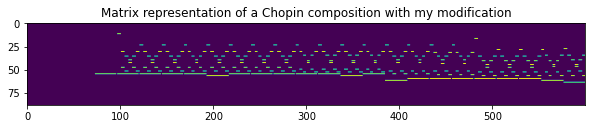

In [26]:
plt.figure(figsize=(10,7))
plt.title("Matrix representation of a Chopin composition with my modification")
plt.imshow(testdata[0][0][:600].numpy().T)
print(f"length of my encoding: {len(testdata[0][0])}")

length of their encoding: 420


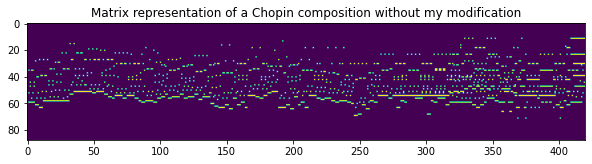

In [21]:
plt.figure(figsize=(10,7))
plt.title("Matrix representation of a Chopin composition without my modification")
plt.imshow(testdata[0][0][:600].numpy().T)
print(f"length of their encoding: {len(testdata[0][0])}")

In [17]:
midiwrite('testout/1.mid', testdata[0][0].numpy(), dtm=0.02)

# My part

## DataLoader

In [17]:
# defining training set and loader
training_dataset = NtGenDataset("Pop-music/train",mx_seq_ln=None)


In [18]:
training_dataloader = data.DataLoader(training_dataset,batch_size=8,shuffle=True,
                                     drop_last=True)

In [20]:
# defining validation set and loader
val_dataset = NtGenDataset("Pop-music/evaluation",mx_seq_ln=5000)


In [21]:

set1 = list(range(0,len(val_dataset),3))
set2 = list(range(1,len(val_dataset),3))
set3 = list(range(2,len(val_dataset),3))
#set4 = list(range(3,len(val_dataset),5))
#set5 = list(range(4,len(val_dataset),5))

val1 = data.Subset(val_dataset,set1)
val2 = data.Subset(val_dataset,set2)
val3 = data.Subset(val_dataset,set3)
#val4 = data.Subset(val_dataset,set4)
#val5 = data.Subset(val_dataset,set5)""

size = 2
val_dataloader1 = data.DataLoader(val1,batch_size=size,shuffle=True)
val_dataloader2 = data.DataLoader(val2,batch_size=size,shuffle=True)
val_dataloader3 = data.DataLoader(val3,batch_size=size,shuffle=True)
#val_dataloader4 = data.DataLoader(val4,batch_size=size,shuffle=True)
#val_dataloader5 = data.DataLoader(val5,batch_size=size,shuffle=True)

val_dataloaders = [val_dataloader1,val_dataloader2,val_dataloader3]


In [22]:
# check data
X_validation = next(iter(val_dataloaders[0]))

ValueError: negative dimensions are not allowed

In [23]:
print(X_validation[0].shape)
#print(X_validation[0][5][0])

torch.Size([2, 32880, 88])


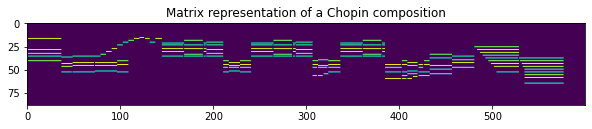

In [24]:
plt.figure(figsize=(10,7))
plt.title("Matrix representation of a Chopin composition")
plt.imshow(X_validation[0][0][-600:].numpy().T)

# Music LSTM

In [16]:
class MusicLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_class, layers=2):
        super(MusicLSTM, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_class = num_class
        self.layers = layers
        self.notes_encoder = nn.Linear(in_features=input_size,out_features=hidden_size)
        self.batchnorm = nn.BatchNorm1d(hidden_size)
        self.lstm = nn.LSTM(hidden_size,hidden_size, layers)
        self.final = nn.Linear(hidden_size,num_class)
    
    def forward(self, sequences, sequence_len, hidden=None):
        notes_encoded = self.notes_encoder(sequences)
        notes_rolled = notes_encoded.permute(1,2,0).contiguous()
        notes_bnormed = self.batchnorm(notes_rolled)
        notes_dropout = nn.Dropout(0.2)(notes_bnormed)
        notes_full = notes_dropout.permute(2,0,1)
        
        # we run rnns only on non-padded regions of the batch
        seq_packed = torch.nn.utils.rnn.pack_padded_sequence(notes_full,sequence_len)
        output, hidden = self.lstm(seq_packed,hidden)
        
        # we unpack sequence
        output, output_length = torch.nn.utils.rnn.pad_packed_sequence(output)
        
        output_bnormed = self.batchnorm(output.permute(1,2,0).contiguous())
        output_dropout = nn.Dropout(0.1)(output_bnormed)
        
        final = self.final(output_dropout.permute(2,0,1))
        final = final.transpose(0,1).contiguous()
        
        neg_final = (1-final)
        
        # there are two "predictions" for each node 
        zero_one_final = torch.stack((final,neg_final),dim=3).contiguous()
        
        # flatten all the nodes so that during the cross entropy, it considers only the proabbility of the key being played
        flatten_final = zero_one_final.view(-1,2)
        
        return flatten_final, hidden
        

In [25]:
class MusicLSTM(nn.Module):
    def __init__(self, input_size = 88, embed_size = 512, hidden_size = 1024, 
                  num_class = 88, layers = 2):
        super(MusicLSTM, self).__init__()
        self.input_size = input_size
        self.embed_size = embed_size
        self.hidden_size = hidden_size
        self.num_class = num_class
        self.layers = layers
        self.notes_encoder = nn.Linear(in_features=input_size, out_features=embed_size)
        self.layernorm_encoder = nn.LayerNorm(embed_size)
        self.layernorm_lstm = nn.LayerNorm(hidden_size)
        self.lstm = nn.LSTM(embed_size,hidden_size,layers)
        self.final = nn.Linear(hidden_size,num_class)
        ###
        #self.final = nn.Linear(hidden_size,128)
        #self.final2 = nn.Linear(128,num_class)
        #self.relu = nn.ReLU()
        ###
        
    # the forgot to traspose the target output, put batch_first in pad_packed_sequence
    #  the encode the music wrong
    def forward(self, sequences, sequence_len, hidden=None):
        # (batch,seq_len,88)
        notes_encoded = self.notes_encoder(sequences)
        notes_rolled = notes_encoded
        notes_lnormed = self.layernorm_encoder(notes_rolled)
        notes_dropout = nn.Dropout(0.2)(notes_lnormed)
        notes_full = notes_dropout
        # (batch,seq_len,88)
        
        # we run rnns only on non-padded regions of the batch
        seq_packed = torch.nn.utils.rnn.pack_padded_sequence(notes_full,sequence_len)
        output, hidden = self.lstm(seq_packed,hidden)
        
        # we unpack sequence
        output, output_length = torch.nn.utils.rnn.pad_packed_sequence(output)
        
        # (batch,seq_len,hidden_size)
        output_lnormed = self.layernorm_lstm(output)
        output_dropout = nn.Dropout(0.1)(output_lnormed)
        
        final = self.final(output_dropout) # final (batch,200,hidden_size) --> 
                                            #                 (batch,200,88)

        
        # final shape (200,batch,88)
        final = final.transpose(0,1).contiguous()
        #print("final shape: ", final.shape)
        
        # create a second measure for prediction per class, shape(seq_len,batch,num_class)
        neg_final = 1 - final
        
        # two "predictions" for each node
        zero_one_final = torch.stack((final,neg_final),dim=3).contiguous()
        
        # flatten everything except for the two predictions dimension
        flatten_final = zero_one_final.view(-1,2)
        
        return flatten_final, hidden
        

# training and validation

In [26]:

def evaluate(model,validation_dataloader,device,loss_fn):
    model.eval()
    val_loss = 0.0
    seq_len = 0.0
    
    for batch in validation_dataloader:
        post_processed = pos_proc_seq(batch)
        input_seq_batch, output_seq_batch, seq_length = post_processed
        output_seq_batch.transpose(0,1).contiguous()
        output_seq_batch_var = Variable(output_seq_batch.contiguous().view(-1).cuda())
        input_seq_batch_var = Variable(input_seq_batch.cuda())
        
        final,_= model(input_seq_batch_var,seq_length)
        loss = loss_fn(final,output_seq_batch_var)

    print("The scaled validation loss is %.6f" % (val_loss/(seq_len*88) * 1000000))
    print()
    return val_loss/(seq_len*88) * 1000000
        

In [27]:
import math
def train(model,trainloader,valloaders,ep,print_freq,loss_fn,
          optimizer,device,run,grad_clip=1.0,mname="LSTM"):
    val_loss_best = float("inf")
    
    # total number of training steps
    num_steps = ep * (len(trainloader))
    progress_bar = tqdm(range(num_steps))
    
    # calculate how often print the result
    #  if num_step = 12, and print_freq = 3, then print every 4 steps
    print_every = math.floor(num_steps/print_freq)
    
    # initialize
    steps = 0
    #model.to(device) ## error when run this twice
    model.train()
    train_losses = []
    val_losses = []
    which_val = 0
    
    for e in range(ep):
        model.train()
        loss_ep = []
        for batch in training_dataloader:
            steps += 1
            post_processed = pos_proc_seq(batch)
            input_seq_batch, output_seq_batch, seq_length = post_processed
            output_seq_batch.transpose(0,1).contiguous()
            output_seq_batch_var = Variable(output_seq_batch.contiguous().view(-1).cuda())
            input_seq_batch_var = Variable(input_seq_batch.cuda())
            
            optimizer.zero_grad()
            final,_ = model(input_seq_batch_var,seq_length)
            loss = loss_fn(final,output_seq_batch_var)
            loss_ep.append(loss.item())
            loss.backward()
            
            torch.nn.utils.clip_grad_norm_(model.parameters(),grad_clip)
            optimizer.step()
            
            progress_bar.update(1)
            
            if steps % print_every == 0:
                current_train_loss = sum(loss_ep)/len(loss_ep)
                print(f"Epoch: {e+1}, training loss = {current_train_loss: .6f}")
                loss_ep = []
                which_val = random.randint(0,2) # now I only have 3 val sets
                val_loss = evaluate(model,valloaders[which_val],device,loss_fn)
                
                if val_loss < val_loss_best:
                    val_loss_best = val_loss
                    torch.save(model.state_dict(),
                     "Weights/"+mname+"-run-{}-val_loss-BEST.pth".format(run))
            model.train()
    torch.save(model.state_dict(),
         "Weights/"+mname+"-run-{}-val_loss-LAST.pth".format(run))

        
            

# experiment


In [29]:
FullSongLSTM = MusicLSTM(hidden_size=512,layers=1).cuda()
loss_fun = nn.CrossEntropyLoss()
optimizer = optim.AdamW(FullSongLSTM.parameters(),lr=1e-4)


In [30]:
train(FullSongLSTM,training_dataloader,val_dataloaders,1,10,
      loss_fun,optimizer,'cuda',1,grad_clip=1.0)

  0%|          | 0/132 [00:00<?, ?it/s]

Epoch: 1, training loss =  0.931299


ZeroDivisionError: float division by zero

# Train!!!!

In [23]:
my_LSTM1 = MusicLSTM(input_size=88,hidden_size=512,num_class=88).cuda()
train(my_LSTM1,lr=0.01,run="1",ep=30)

Epoch: 1, training loss =  1.4544
validation loss = 0.6242

Epoch: 2, training loss =  0.5585
validation loss = 0.3107

Epoch: 3, training loss =  0.2932
validation loss = 0.2464

Epoch: 4, training loss =  0.1696
validation loss = 0.2142

Epoch: 5, training loss =  0.1531
validation loss = 0.2112

Epoch: 6, training loss =  0.1489
validation loss = 0.2158

Epoch: 7, training loss =  0.1534
validation loss = 0.2176

Epoch: 8, training loss =  0.1497
validation loss = 0.2260

Epoch: 9, training loss =  0.1477
validation loss = 0.2063

Epoch: 10, training loss =  0.1543
validation loss = 0.1988

Epoch: 11, training loss =  0.1475
validation loss = 0.2009

Epoch: 12, training loss =  0.1445
validation loss = 0.1976

Epoch: 13, training loss =  0.1507
validation loss = 0.1951

Epoch: 14, training loss =  0.1474
validation loss = 0.1985

Epoch: 15, training loss =  0.1455
validation loss = 0.1977

Epoch: 16, training loss =  0.1448
validation loss = 0.1955

Epoch: 17, training loss =  0.148

In [202]:
my_LSTM1.load_state_dict(torch.load("Weights/LSTM1-run-1-val_loss-0.2038.pth"))
train(my_LSTM1,lr=1e-3,run="2",ep=50)

Epoch: 1, training loss =  0.1603
validation loss = 0.1856

Epoch: 2, training loss =  0.1548
validation loss = 0.2135

Epoch: 3, training loss =  0.1543
validation loss = 0.2106

Epoch: 4, training loss =  0.1521
validation loss = 0.1778

Epoch: 5, training loss =  0.1481
validation loss = 0.1954

Epoch: 6, training loss =  0.1488
validation loss = 0.1920

Epoch: 7, training loss =  0.1454
validation loss = 0.1967

Epoch: 8, training loss =  0.1535
validation loss = 0.1733

Epoch: 9, training loss =  0.1509
validation loss = 0.1997

Epoch: 10, training loss =  0.1533
validation loss = 0.1736

Epoch: 11, training loss =  0.1463
validation loss = 0.1732

Epoch: 12, training loss =  0.1436
validation loss = 0.1847

Epoch: 13, training loss =  0.1496
validation loss = 0.1835

Epoch: 14, training loss =  0.1399
validation loss = 0.1753

Epoch: 15, training loss =  0.1424
validation loss = 0.1767

Epoch: 16, training loss =  0.1411
validation loss = 0.1762

Epoch: 17, training loss =  0.141

In [209]:
train(my_LSTM1,lr=1e-3,run="3",ep=50)

Epoch: 1, training loss =  0.1314
validation loss = 0.1561

Epoch: 2, training loss =  0.1250
validation loss = 0.1617

Epoch: 3, training loss =  0.1244
validation loss = 0.1618

Epoch: 4, training loss =  0.1237
validation loss = 0.1571

Epoch: 5, training loss =  0.1236
validation loss = 0.1573

Epoch: 6, training loss =  0.1258
validation loss = 0.1610

Epoch: 7, training loss =  0.1242
validation loss = 0.1577

Epoch: 8, training loss =  0.1256
validation loss = 0.1567

Epoch: 9, training loss =  0.1234
validation loss = 0.1578

Epoch: 10, training loss =  0.1246
validation loss = 0.1572

Epoch: 11, training loss =  0.1229
validation loss = 0.1523

Epoch: 12, training loss =  0.1262
validation loss = 0.1621

Epoch: 13, training loss =  0.1205
validation loss = 0.1576

Epoch: 14, training loss =  0.1203
validation loss = 0.1606

Epoch: 15, training loss =  0.1223
validation loss = 0.1554

Epoch: 16, training loss =  0.1157
validation loss = 0.1566

Epoch: 17, training loss =  0.122

In [220]:
train(my_LSTM1,lr=1e-3,run="4",ep=50)

Epoch: 1, training loss =  0.1133
validation loss = 0.1611

Epoch: 2, training loss =  0.1119
validation loss = 0.1675

Epoch: 3, training loss =  0.1129
validation loss = 0.1621

Epoch: 4, training loss =  0.1174
validation loss = 0.1620

Epoch: 5, training loss =  0.1145
validation loss = 0.1696

Epoch: 6, training loss =  0.1126
validation loss = 0.1648

Epoch: 7, training loss =  0.1159
validation loss = 0.1704

Epoch: 8, training loss =  0.1128
validation loss = 0.1617

Epoch: 9, training loss =  0.1063
validation loss = 0.1627

Epoch: 10, training loss =  0.1110
validation loss = 0.1685

Epoch: 11, training loss =  0.1067
validation loss = 0.1644

Epoch: 12, training loss =  0.1078
validation loss = 0.1719

Epoch: 13, training loss =  0.1077
validation loss = 0.1659

Epoch: 14, training loss =  0.1067
validation loss = 0.1640

Epoch: 15, training loss =  0.1031
validation loss = 0.1649

Epoch: 16, training loss =  0.1095
validation loss = 0.1680

Epoch: 17, training loss =  0.109

In [233]:
train(my_LSTM1,lr=1e-3,run="5",ep=50)

Epoch: 1, training loss =  0.1008
validation loss = 0.1682

Epoch: 2, training loss =  0.1079
validation loss = 0.1758

Epoch: 3, training loss =  0.1077
validation loss = 0.1700

Epoch: 4, training loss =  0.1068
validation loss = 0.1722

Epoch: 5, training loss =  0.1032
validation loss = 0.1709

Epoch: 6, training loss =  0.1125
validation loss = 0.1704

Epoch: 7, training loss =  0.1028
validation loss = 0.1693

Epoch: 8, training loss =  0.1083
validation loss = 0.1687

Epoch: 9, training loss =  0.1053
validation loss = 0.1684

Epoch: 10, training loss =  0.1034
validation loss = 0.1718

Epoch: 11, training loss =  0.1018
validation loss = 0.1684

Epoch: 12, training loss =  0.1071
validation loss = 0.1642

Epoch: 13, training loss =  0.1003
validation loss = 0.1722

Epoch: 14, training loss =  0.1000
validation loss = 0.1696

Epoch: 15, training loss =  0.0985
validation loss = 0.1675

Epoch: 16, training loss =  0.1015
validation loss = 0.1707

Epoch: 17, training loss =  0.101

# with more data

In [25]:
torch.save(my_LSTM1.state_dict(),"Weights/LSTM1_full-run-1-epoch-30.pth")

Epoch: 1, training loss =  0.2390
validation loss = 0.3566

Epoch: 2, training loss =  0.2019
validation loss = 0.2664

Epoch: 3, training loss =  0.1662
validation loss = 0.2264

Epoch: 4, training loss =  0.1588
validation loss = 0.2090

Epoch: 5, training loss =  0.1507
validation loss = 0.1849

Epoch: 6, training loss =  0.1473
validation loss = 0.1831

Epoch: 7, training loss =  0.1430
validation loss = 0.1975

Epoch: 8, training loss =  0.1426
validation loss = 0.1777

Epoch: 9, training loss =  0.1418
validation loss = 0.1802

Epoch: 10, training loss =  0.1436
validation loss = 0.1744

Epoch: 11, training loss =  0.1386
validation loss = 0.1784

Epoch: 12, training loss =  0.1380
validation loss = 0.1727

Epoch: 13, training loss =  0.1391
validation loss = 0.1743

Epoch: 14, training loss =  0.1389
validation loss = 0.1743

Epoch: 15, training loss =  0.1402
validation loss = 0.1720

Epoch: 16, training loss =  0.1367
validation loss = 0.1672

Epoch: 17, training loss =  0.136

W:\Tools\Anaconda3\envs\pytorch\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


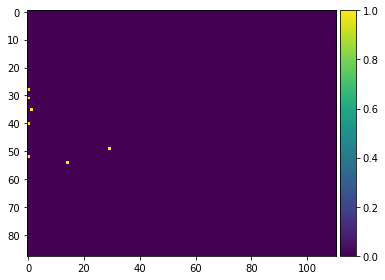

In [35]:
# starting from 31 epoch
train(my_LSTM1,lr=0.01,run="2",ep=30)

In [42]:

train(my_LSTM1,lr=1e-3,run="3",ep=50)

Epoch: 1, training loss =  0.1331
validation loss = 0.1615

Epoch: 2, training loss =  0.1351
validation loss = 0.1609

Epoch: 3, training loss =  0.1356
validation loss = 0.1604

Epoch: 4, training loss =  0.1334
validation loss = 0.1610

Epoch: 5, training loss =  0.1341
validation loss = 0.1596

Epoch: 6, training loss =  0.1327
validation loss = 0.1603

Epoch: 7, training loss =  0.1325
validation loss = 0.1595

Epoch: 8, training loss =  0.1324
validation loss = 0.1601

Epoch: 9, training loss =  0.1320
validation loss = 0.1596

Epoch: 10, training loss =  0.1307
validation loss = 0.1592

Epoch: 11, training loss =  0.1336
validation loss = 0.1600

Epoch: 12, training loss =  0.1303
validation loss = 0.1597

Epoch: 13, training loss =  0.1320
validation loss = 0.1589

Epoch: 14, training loss =  0.1287
validation loss = 0.1591

Epoch: 15, training loss =  0.1294
validation loss = 0.1588

Epoch: 16, training loss =  0.1318
validation loss = 0.1581

Epoch: 17, training loss =  0.129

In [52]:
train(my_LSTM1,lr=1e-3,run="4",ep=100)

Epoch: 10, training loss =  0.1290
validation loss = 0.1589

Epoch: 20, training loss =  0.1270
validation loss = 0.1569

Epoch: 30, training loss =  0.1249
validation loss = 0.1574

Epoch: 40, training loss =  0.1281
validation loss = 0.1593

Epoch: 50, training loss =  0.1248
validation loss = 0.1586

Epoch: 60, training loss =  0.1274
validation loss = 0.1599

Epoch: 70, training loss =  0.1229
validation loss = 0.1622

Epoch: 80, training loss =  0.1258
validation loss = 0.1629

Epoch: 90, training loss =  0.1231
validation loss = 0.1614

Epoch: 100, training loss =  0.1206
validation loss = 0.1641



In [53]:
train(my_LSTM1,lr=1e-3,run="5",ep=100)

Epoch: 10, training loss =  0.1243
validation loss = 0.1649

Epoch: 20, training loss =  0.1174
validation loss = 0.1672

Epoch: 30, training loss =  0.1176
validation loss = 0.1672

Epoch: 40, training loss =  0.1203
validation loss = 0.1679

Epoch: 50, training loss =  0.1205
validation loss = 0.1666

Epoch: 60, training loss =  0.1189
validation loss = 0.1666

Epoch: 70, training loss =  0.1179
validation loss = 0.1688

Epoch: 80, training loss =  0.1224
validation loss = 0.1683

Epoch: 90, training loss =  0.1183
validation loss = 0.1705

Epoch: 100, training loss =  0.1191
validation loss = 0.1711



In [77]:
train(my_LSTM1,lr=1e-3,run="6",ep=100)

Epoch: 10, training loss =  0.1169
validation loss = 0.1737

Epoch: 20, training loss =  0.1216
validation loss = 0.1768

Epoch: 30, training loss =  0.1181
validation loss = 0.1752

Epoch: 40, training loss =  0.1196
validation loss = 0.1761

Epoch: 50, training loss =  0.1157
validation loss = 0.1782

Epoch: 60, training loss =  0.1192
validation loss = 0.1788

Epoch: 70, training loss =  0.1180
validation loss = 0.1788

Epoch: 80, training loss =  0.1181
validation loss = 0.1803

Epoch: 90, training loss =  0.1183
validation loss = 0.1802

Epoch: 100, training loss =  0.1129
validation loss = 0.1833



In [84]:
train(my_LSTM1,lr=1e-3,run="7",ep=100)

Epoch: 10, training loss =  0.1185
validation loss = 0.1848

Epoch: 20, training loss =  0.1152
validation loss = 0.1831

Epoch: 30, training loss =  0.1152
validation loss = 0.1860

Epoch: 40, training loss =  0.1162
validation loss = 0.1812

Epoch: 50, training loss =  0.1130
validation loss = 0.1867

Epoch: 60, training loss =  0.1168
validation loss = 0.1888

Epoch: 70, training loss =  0.1149
validation loss = 0.1849

Epoch: 80, training loss =  0.1155
validation loss = 0.1867

Epoch: 90, training loss =  0.1191
validation loss = 0.1867

Epoch: 100, training loss =  0.1135
validation loss = 0.1883



In [25]:
train(my_LSTM1,lr=1e-3,run="00",ep=2)

# generate samples

In [28]:
def generate_music(lstm_model, ln=100, tmp=1, seq_st=None):
    if seq_st is None:
        seq_ip_cur = torch.zeros(1, 1, 88)
        seq_ip_cur[0, 0, 15] = 0 # C
        seq_ip_cur[0, 0, 22] = 0 # G
        
        
        seq_ip_cur[0, 0, 27] = 0 # C
        seq_ip_cur[0, 0, 28] = 1
        seq_ip_cur[0, 0, 31] = 0
        
        seq_ip_cur[0, 0, 39] = 0 # C
        seq_ip_cur[0, 0, 40] = 0
        seq_ip_cur[0, 0, 43] = 1
        seq_ip_cur[0, 0, 46] = 0
        
        seq_ip_cur[0, 0, 51] = 0 # C
        seq_ip_cur[0, 0, 52] = 1
        seq_ip_cur = Variable(seq_ip_cur.cuda())
    else:
        seq_ip_cur = seq_st
        
    op_seq = [seq_ip_cur.data.squeeze(1)]
    hd = None

    for i in range(ln):
        print("iteration: ", i)
        print("input sequence, ", seq_ip_cur)
        op, hd = lstm_model(seq_ip_cur, [1], hd)
        print("output ",op)
        print("hidden layer, ", hd)
        probs = nn.functional.softmax(op.div(tmp), dim=1)
        print("probs, ", probs)
        seq_ip_cur = torch.multinomial(probs.data, 1).squeeze().unsqueeze(0).unsqueeze(1)
        print("probs.data, ", probs.data)
        print("multinomial, ", torch.multinomial(probs.data,1))
        print("current seq, ", seq_ip_cur)
        seq_ip_cur = Variable(seq_ip_cur.float())
        print("variable current seq, ", seq_ip_cur)
        op_seq.append(seq_ip_cur.data.squeeze(1))
        print("output sequence: ", op_seq)

    gen_seq = torch.cat(op_seq, dim=0).cpu().numpy()
    
    return gen_seq

In [175]:
seq_st = X_validation[0][0][0].cuda()
seq_st.shape

torch.Size([88])

iteration:  0
input sequence,  tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
          0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0.]]], device='cuda:0')
output  tensor([[ 24.3230, -23.3230],
        [ 13.8498, -12.8498],
        [ 16.3757, -15.3757],
        [ 15.7094, -14.7094],
        [ 15.4395, -14.4395],
        [ 18.5934, -17.5934],
        [ 13.8819, -12.8819],
        [ 12.1265, -11.1265],
        [ 12.7576, -11.7576],
        [ 11.3493, -10.3493],
        [ 12.5521, -11.5521],
        [  6.5246,  -5.5246],
        [ 12.1959, -11.1959],
        [  9.0377,  -8.0377],
        [ 10.4156,  -9.4156],
        [ 12.1693, -11.1693],
        [  7.5452,  -6.5452],
        [ 11.8787, 

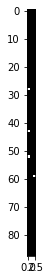

In [29]:
#my_LSTM1.load_state_dict(torch.load("Weights/LSTM1-run-2-val_loss-0.3124.pth"))
#seq_st = X_validation[0][0].cuda()
seq = generate_music(my_LSTM1, ln=2, tmp=0.8, seq_st=None).transpose()
io.imshow(seq)
midiwrite('generated_music.mid', seq.transpose(), dtm=0.25)

In [74]:
import IPython
from IPython.display import Image, Audio
IPython.display.Audio("generated_music.mid")

4-59-0.7, 4-79-0.7, 4-99-0.8, 5-19-0.9, 5-39-0.7, 5-59-0.7, 5-79-0.7, 5-79-0.8
5-79-0.9, 5-99-0.7, ..., 6-99-0.7*, 6-test*

In [20]:
my_LSTM1 = MusicLSTM(input_size=88,hidden_size=512,num_class=88).cuda()

In [24]:
my_LSTM1.load_state_dict(torch.load("Weights/LSTM1_full-run-6-epoch-100-val_loss-0.1833.pth"))
#seq_st = X_validation[0][0].cuda()
seq = generate_music(my_LSTM1, ln=100, tmp=1, seq_st=None).transpose()
io.imshow(seq)
midiwrite('generated_music.mid', seq.transpose(), dtm=0.25)

ValueError: Expected more than 1 value per channel when training, got input size torch.Size([1, 512, 1])